# Preprocess Datasets for Korean LLM (Large Language Model) fine-tuning
---

- Alpaca 논문에서 전처리했던 방식대로 전처리 수행
- 허깅페이스 인증 정보 설정: `huggingface-cli login`
    - https://huggingface.co/join
    - https://huggingface.co/settings/tokens

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../utils')
sys.path.append('../templates')

from common_lib import check_packages
check_packages()

Proceed.


<br>

## 1. Download LLM from Hugging Face hub
---

### Load dataset
허깅페이스 허브에서 다운로드하거나 json/json 포맷의 데이터 세트를 다운로드합니다. 데이터 세트 내 샘플은 (`instruction, input, output`)의 key-value나 (`instruction, output`)의 key-value로 구성되어야 합니다.

예시:
```
{
    "instruction":"건강을 유지하기 위한 세 가지 팁을 알려주세요.",
    "input":"",
    "output":"세 가지 팁은 아침식사를 꼭 챙기며, 충분한 수면을 취하고, 적극적으로 운동을 하는 것입니다."
}
```

In [2]:
import os
import torch
import transformers
from datasets import load_dataset
from inference_lib import Prompter
from transformers import GPTNeoXForCausalLM, GPTNeoXTokenizerFast

data_path = "nlpai-lab/kullm-v2"
#data_path = "beomi/KoAlpaca-v1.1a"
#data_path = "./data/ko_alpaca_data.json"

if data_path.endswith(".json") or data_path.endswith(".jsonl"):
    data = load_dataset("json", data_files=data_path)
else:
    data = load_dataset(data_path)
    
prompter = Prompter("kullm")
cutoff_len = 2048
train_on_inputs = True

[2023-09-05 18:46:06,329] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [7]:
import os
from pathlib import Path
from huggingface_hub import snapshot_download

HF_MODEL_ID = "nlpai-lab/kullm-polyglot-12.8b-v2"

tokenizer = GPTNeoXTokenizerFast.from_pretrained(HF_MODEL_ID)

# Only download pytorch checkpoint files
allow_patterns = ["*.json", "*.pt", "*.bin", "*.txt", "*.model"]

# create model dir
model_name = HF_MODEL_ID.split("/")[-1].replace('.', '-')
model_tar_dir = Path(f"/home/ec2-user/SageMaker/models/{model_name}")
if not os.path.isdir(model_tar_dir):
    os.makedirs(model_tar_dir, exist_ok=True)
    # Download model from Hugging Face into model_dir
    snapshot_download(
        HF_MODEL_ID, 
        local_dir=str(model_tar_dir), 
        local_dir_use_symlinks=False,
        allow_patterns=allow_patterns,
        cache_dir="/home/ec2-user/SageMaker/"
    )

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'GPTNeoXTokenizerFast'.


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

# 데이터 살펴보기

데이터 구조
- id: 각 데이터 포인트의 고유 식별자
- instruction: 사용자의 질문 또는 명령
- input: 추가 입력 (여기서는 비어 있음)
- output: 질문 또는 명령에 대한 답변

In [44]:
# 데이터셋의 처음 3개 샘플을 출력
print(data['train'][:3])

{'id': ['alpaca_{idx}', 'alpaca_{idx}', 'alpaca_{idx}'], 'instruction': ['3원색이란 무엇인가요?', '어려운 결정을 내려야 했던 순간을 설명해 주세요.', '원자의 구조를 설명합니다.'], 'input': ['', '', ''], 'output': ['세 가지 기본 색은 빨강, 파랑, 노랑입니다. 이 색은 다른 색을 혼합하여 만들 수 없고 다른 모든 색은 다양한 비율로 조합하여 만들 수 있기 때문에 원색이라고 부릅니다. 빛에 사용되는 첨가제 색상 시스템에서 원색은 빨강, 녹색, 파랑(RGB)입니다.', 'AI 어시스턴트인 저는 저만의 개인적인 경험이나 물리적 존재를 가지고 있지 않습니다. 하지만 알고리즘, 논리, 데이터를 기반으로 의사 결정을 내리도록 프로그래밍되어 있습니다. 상충되는 정보나 여러 가지 가능한 결과가 있을 수 있기 때문에 의사결정이 어려운 상황에 직면할 때가 있습니다. 그런 경우 저는 각 옵션의 위험과 이점을 분석하고 비교하여 원하는 결과를 얻을 가능성이 가장 높은 결론에 도달할 수 있는 능력을 활용합니다.', '원자는 모든 물질의 기본 구성 요소이며 양성자, 중성자, 전자의 세 가지 유형의 입자로 이루어져 있습니다. 원자의 구조는 전자 구름으로 둘러싸인 중앙에 핵이 있는 것으로 설명할 수 있습니다.\n\n원자의 핵은 양성자와 중성자로 구성됩니다. 양성자는 양전하를 띠는 입자이고 중성자는 전하를 띠지 않는 중성 입자입니다. 이 두 입자는 원자의 중심에 있으며 원자 질량의 대부분을 차지하는 원자핵에 위치합니다.\n\n원자핵을 둘러싸고 있는 것은 전자 구름입니다. 전자는 음전하를 띠는 입자로, 원자핵 주변에서 끊임없이 움직입니다. 전자 구름은 껍질 또는 궤도로 나뉘며, 각 껍질은 특정 수의 전자를 보유할 수 있습니다. 원자가 껍질이라고 하는 가장 바깥쪽 껍질에 있는 전자의 수에 따라 원자의 화학적 특성이 결정됩니다.\n\n중성 원자에서 핵의 양성자 수는 전자 구름의 전자 수와 같으므로 양전

### 기본 통계량 계산
문장의 길이, 단어의 개수, 고유 단어의 개수 등을 계산합니다.

In [45]:
import pandas as pd

# 데이터셋을 pandas DataFrame으로 변환
df = pd.DataFrame(data['train'])

df

,id,instruction,input,output
0,alpaca_{idx},3원색이란 무엇인가요?,,"세 가지 기본 색은 빨강, 파랑, 노랑입니다. 이 색은 다른 색을 혼합하여 만들 수..."
1,alpaca_{idx},어려운 결정을 내려야 했던 순간을 설명해 주세요.,,AI 어시스턴트인 저는 저만의 개인적인 경험이나 물리적 존재를 가지고 있지 않습니다...
2,alpaca_{idx},원자의 구조를 설명합니다.,,"원자는 모든 물질의 기본 구성 요소이며 양성자, 중성자, 전자의 세 가지 유형의 입..."
3,alpaca_{idx},대기 오염을 줄이려면 어떻게 해야 할까요?,,대기 오염을 줄이는 방법에는 다음과 같은 여러 가지가 있습니다:\n\n1. 에너지 ...
4,alpaca_{idx},건강을 유지하기 위한 세 가지 팁을 알려주세요.,,"1. 균형 잡힌 영양가 있는 식단을 섭취합니다: 식단에 다양한 과일과 채소, 저지방..."
...,...,...,...,...
152625,vicuna_{idx},자세히 보기,,7가지 동영상 제목 아이디어가 더 있습니다:1. 시청자를 교육하고 신뢰를 구축하는 ...
152626,vicuna_{idx},"저는 다양한 직원의 순간(온보딩부터 오프보딩까지, 그리고 그 사이에 결혼, 질병 등...",,직원의 중요한 순간을 위한 허브 사이트를 만들게 된 것을 축하합니다! 퇴직을 오프보...
152627,vicuna_{idx},이미지가 PDF로 저장됩니다. 다르게 처리해야 하나요? 일부 PDF에는 이러한 출석...,,"예, PDF 페이지에서 이미지를 먼저 추출해야 하므로 PDF 파일을 다른 방식으로 ..."
152628,vicuna_{idx},더 많은 아이디어 제공,,비감염성 질환 문제를 해결하기 위한 웹사이트 아이디어를 몇 가지 더 소개합니다:1....


In [47]:
# 문장 길이, 단어 수 등 기본 통계량 계산
df['instruction_length'] = df['instruction'].apply(len)
df['input_length'] = df['input'].apply(len)
df['output_length'] = df['output'].apply(len)

print(df.describe())
df

       instruction_length   input_length  output_length
count       152630.000000  152630.000000  152630.000000
mean           159.659209      21.391404     653.133519
std            571.326172     149.934448     617.208994
min              0.000000       0.000000       0.000000
25%             23.000000       0.000000     171.000000
50%             33.000000       0.000000     529.000000
75%             57.000000       0.000000     912.000000
max          23515.000000    9244.000000    6079.000000


,id,instruction,input,output,instruction_length,input_length,output_length
0,alpaca_{idx},3원색이란 무엇인가요?,,"세 가지 기본 색은 빨강, 파랑, 노랑입니다. 이 색은 다른 색을 혼합하여 만들 수...",12,0,140
1,alpaca_{idx},어려운 결정을 내려야 했던 순간을 설명해 주세요.,,AI 어시스턴트인 저는 저만의 개인적인 경험이나 물리적 존재를 가지고 있지 않습니다...,27,0,238
2,alpaca_{idx},원자의 구조를 설명합니다.,,"원자는 모든 물질의 기본 구성 요소이며 양성자, 중성자, 전자의 세 가지 유형의 입...",14,0,508
3,alpaca_{idx},대기 오염을 줄이려면 어떻게 해야 할까요?,,대기 오염을 줄이는 방법에는 다음과 같은 여러 가지가 있습니다:\n\n1. 에너지 ...,23,0,712
4,alpaca_{idx},건강을 유지하기 위한 세 가지 팁을 알려주세요.,,"1. 균형 잡힌 영양가 있는 식단을 섭취합니다: 식단에 다양한 과일과 채소, 저지방...",26,0,402
...,...,...,...,...,...,...,...
152625,vicuna_{idx},자세히 보기,,7가지 동영상 제목 아이디어가 더 있습니다:1. 시청자를 교육하고 신뢰를 구축하는 ...,7,0,280
152626,vicuna_{idx},"저는 다양한 직원의 순간(온보딩부터 오프보딩까지, 그리고 그 사이에 결혼, 질병 등...",,직원의 중요한 순간을 위한 허브 사이트를 만들게 된 것을 축하합니다! 퇴직을 오프보...,141,0,1000
152627,vicuna_{idx},이미지가 PDF로 저장됩니다. 다르게 처리해야 하나요? 일부 PDF에는 이러한 출석...,,"예, PDF 페이지에서 이미지를 먼저 추출해야 하므로 PDF 파일을 다른 방식으로 ...",80,0,1532
152628,vicuna_{idx},더 많은 아이디어 제공,,비감염성 질환 문제를 해결하기 위한 웹사이트 아이디어를 몇 가지 더 소개합니다:1....,12,0,1222


In [22]:
print(df.columns)

Index(['id', 'instruction', 'input', 'output', 'instruction_length',
       'input_length', 'output_length'],
      dtype='object')


### 문장 길이, 단어 빈도 등을 시각화

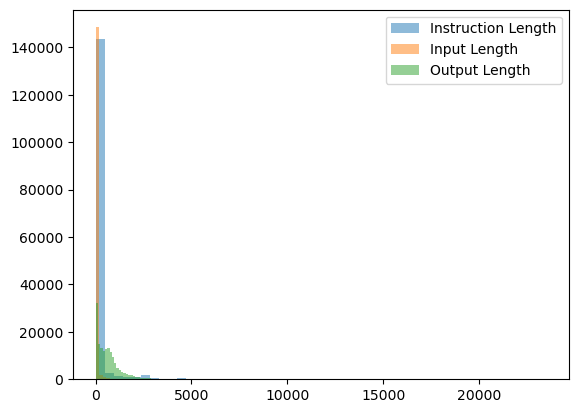

In [11]:
import matplotlib.pyplot as plt

# 문장 길이 분포 시각화
plt.hist(df['instruction_length'], bins=50, alpha=0.5, label='Instruction Length')
plt.hist(df['input_length'], bins=50, alpha=0.5, label='Input Length')
plt.hist(df['output_length'], bins=50, alpha=0.5, label='Output Length')
plt.legend(loc='upper right')
plt.show()

### 고유 단어 및 빈도수 분석

In [15]:
from collections import Counter

# 모든 문장을 단어로 분리
all_words = ' '.join(df['instruction']).split()

# 단어 빈도수 계산
word_freq = Counter(all_words)

# 가장 자주 등장하는 단어 10개
print('가장 자주 등장하는 단어 10개 : ', word_freq.most_common(10))
print('\n')
# 가장 드물게 등장하는 단어 10개
print('가장 드물게 등장하는 단어 10개 : ', word_freq.most_common()[:-11:-1])


가장 자주 등장하는 단어 10개 :  [('수', 54541), ('=', 37405), ('대한', 30755), ('이', 25735), ('및', 25516), ('있는', 22676), ('있습니다.', 18468), ('-', 16558), ('더', 15042), ('{', 14709)]


가장 드물게 등장하는 단어 10개 :  [('바이러스에만', 1), ('항바이러스제는', 1), ('PDF에는', 1), ('퇴직입니다(오프보딩과', 1), ('이벤트)으로', 1), ('결혼,', 1), ('오프보딩까지,', 1), ('순간(온보딩부터', 1), ('Peter의', 1), ('신규자', 1)]


<br>

## 2. Tokenize
---
목적: 텍스트를 더 작은 부분, 즉 "토큰(token)"으로 분리하는 과정입니다.
단위: 보통 단어, 문장, 문단 등을 토큰으로 분리합니다. 하지만 언어와 문맥에 따라 다를 수 있습니다.

### NLP에서 Tokenization

#### Tokenization (토큰화)

**정의**: 토큰화는 큰 문단을 문장, 단어 또는 다른 단위로 분해하는 과정입니다. 이 과정은 텍스트의 구조를 이해하는 데 필수적이며, 자연어 처리(NLP)에서 종종 첫 번째 단계 중 하나입니다.

**사용 사례**: 
- 텍스트 분류
- 감정 분석
- 기계 번역

**예시**: 
```text
입력: "안녕하세요, 세상! 어떻게 지내세요?"
토큰: ["안녕하세요", ",", "세상", "!", "어떻게", "지내세요", "?"]
```

**장점**:
- 단순하고 빠름
- 추가적인 텍스트 분석의 기초가 됨

**단점**:
- 단어 사이의 문맥과 의미 관계를 잃음
- 관용 표현을 잘 처리하지 못할 수 있음

---

In [23]:
def tokenize(prompt, add_eos_token=True):
    # there's probably a way to do this with the tokenizer settings
    # but again, gotta move fast
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=cutoff_len,
        padding=False,
        return_tensors=None,
    )
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and len(result["input_ids"]) < cutoff_len
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    result["labels"] = result["input_ids"].copy()

    return result

def generate_and_tokenize_prompt(data_point):
    full_prompt = prompter.generate_prompt(
        data_point["instruction"],
        data_point.get("input"),
        data_point["output"],
    )
    tokenized_full_prompt = tokenize(full_prompt)
    if not train_on_inputs:
        user_prompt = prompter.generate_prompt(data_point["instruction"], data_point.get("input"))
        tokenized_user_prompt = tokenize(user_prompt, add_eos_token=add_eos_token)
        user_prompt_len = len(tokenized_user_prompt["input_ids"])

        if add_eos_token:
            user_prompt_len -= 1

        tokenized_full_prompt["labels"] = [-100] * user_prompt_len + tokenized_full_prompt["labels"][
            user_prompt_len:
        ]  # could be sped up, probably
    return tokenized_full_prompt


In [24]:
dataset = data['train'].shuffle()#.select(range(100))
lm_dataset = dataset.map(generate_and_tokenize_prompt)

# Print total number of samples
print(f"Total number of samples: {len(lm_dataset)}")

Map:   0%|          | 0/152630 [00:00<?, ? examples/s]

Total number of samples: 152630


In [27]:
df_lm = lm_dataset.to_pandas()
df_lm

,id,instruction,input,output,input_ids,attention_mask,labels
0,alpaca_{idx},2020년 시가총액 기준 상위 5개 기술 기업 파악하기,,2020년 5월 기준 포브스 글로벌 2000 리스트와 시가총액에 따르면 상위 5개 ...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
1,dolly_{idx},세계에서 가장 오래된 도시의 이름은 무엇인가요?,,세계에서 가장 오래된 도시 중 하나로 알려진 곳은 이집트의 룩소르(Luxor)입니다...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
2,vicuna_{idx},이제 100개의 서로 다른 메시지 환자가 포함된 긴 목록을 알려드리겠습니다. 각각의...,,다음은 각 메시지를 카테고리와 일치시키는 테이블입니다:\r\n\r\n| 메시지 | ...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
3,vicuna_{idx},이 글의 네 번째 부분입니다.인용{weber2009data}의 데이터 세트는 개막 ...,,다른 질문이 있거나 도움이 필요하면 언제든지 알려주세요.,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
4,alpaca_{idx},태양 전지판의 조직 구조를 설명합니다.,,태양광 패널은 패널 표면에 격자형 패턴으로 배열된 여러 개의 태양광 셀로 구성됩니다...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
...,...,...,...,...,...,...,...
152625,alpaca_{idx},단어는 동일하게 유지하되 의미가 달라지도록 다음 문장을 다시 작성합니다.,그녀가 해냈습니다.,그녀가 해냈나요?,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
152626,alpaca_{idx},남미의 지정학적 상황을 요약하세요.,,"남미는 다양하고 복잡한 지정학적 현실을 가진 지역으로, 12개의 주권 국가가 있으며...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
152627,vicuna_{idx},"다음과 같은 프롬프트 / 상상 스타일로 포맷합니다: ""은하, 나선, 우주, 성운, ...",,"P""AWA 도미니카나, 화려함, 생동감, 장난기, 해변, 야자수, 일몰, 시구아 팔...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."
152628,vicuna_{idx},C++를 통해 OpenGL을 공부하는 방법은?,,C++를 통해 OpenGL을 학습하려면 다음 단계를 따르세요:1. C++ 프로그래밍...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ..."


In [34]:
# 'input_ids' 칼럼의 각 벡터의 길이를 새로운 칼럼 'input_ids_length'에 저장
df_lm['input_ids_length'] = df_lm['input_ids'].apply(len)

# 새로운 칼럼을 확인
df_lm

,id,instruction,input,output,input_ids,attention_mask,labels,input_ids_length
0,alpaca_{idx},2020년 시가총액 기준 상위 5개 기술 기업 파악하기,,2020년 5월 기준 포브스 글로벌 2000 리스트와 시가총액에 따르면 상위 5개 ...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",192
1,dolly_{idx},세계에서 가장 오래된 도시의 이름은 무엇인가요?,,세계에서 가장 오래된 도시 중 하나로 알려진 곳은 이집트의 룩소르(Luxor)입니다...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",143
2,vicuna_{idx},이제 100개의 서로 다른 메시지 환자가 포함된 긴 목록을 알려드리겠습니다. 각각의...,,다음은 각 메시지를 카테고리와 일치시키는 테이블입니다:\r\n\r\n| 메시지 | ...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",2048
3,vicuna_{idx},이 글의 네 번째 부분입니다.인용{weber2009data}의 데이터 세트는 개막 ...,,다른 질문이 있거나 도움이 필요하면 언제든지 알려주세요.,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",1013
4,alpaca_{idx},태양 전지판의 조직 구조를 설명합니다.,,태양광 패널은 패널 표면에 격자형 패턴으로 배열된 여러 개의 태양광 셀로 구성됩니다...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",363
...,...,...,...,...,...,...,...,...
152625,alpaca_{idx},단어는 동일하게 유지하되 의미가 달라지도록 다음 문장을 다시 작성합니다.,그녀가 해냈습니다.,그녀가 해냈나요?,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",96
152626,alpaca_{idx},남미의 지정학적 상황을 요약하세요.,,"남미는 다양하고 복잡한 지정학적 현실을 가진 지역으로, 12개의 주권 국가가 있으며...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",353
152627,vicuna_{idx},"다음과 같은 프롬프트 / 상상 스타일로 포맷합니다: ""은하, 나선, 우주, 성운, ...",,"P""AWA 도미니카나, 화려함, 생동감, 장난기, 해변, 야자수, 일몰, 시구아 팔...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",162
152628,vicuna_{idx},C++를 통해 OpenGL을 공부하는 방법은?,,C++를 통해 OpenGL을 학습하려면 다음 단계를 따르세요:1. C++ 프로그래밍...,"[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12657, 272, 2236, 276, 1251, 284, 272, 5026, ...",605


#### 토크나이징 벡터의 최대 길이는 설정한 cutoff_len로 고정됨

In [38]:
# 'input_ids_length' 칼럼의 최대값을 확인
max_value = df_lm['input_ids_length'].max()

print(f"The maximum length of 'input_ids' is {max_value}")

The maximum length of 'input_ids' is 2048


<br>

## 3. Save dataset to S3
---

In [39]:
import sagemaker
import boto3
sess = sagemaker.Session()
region = boto3.Session().region_name
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
bucket = None
if bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=bucket)

print(f"SageMaker role arn: {role}")
print(f"SageMaker bucket: {sess.default_bucket()}")
print(f"SageMaker session region: {sess.boto_region_name}")

SageMaker role arn: arn:aws:iam::740128158828:role/SagemakerWorkshopFullAccessRole
SageMaker bucket: sagemaker-us-east-1-740128158828
SageMaker session region: us-east-1


In [40]:
bucket_prefix = 'ko-llms/peft'
dataset_prefix = 'alpaca-train'
s3_data_path = f"s3://{bucket}/{bucket_prefix}/{model_name}/dataset/{dataset_prefix}"
s3_pretrained_model_path = f"s3://{bucket}/{bucket_prefix}/huggingface-models/{model_name}/"
print(f"S3 data path: \n {s3_data_path}")
print(f"S3 pretrained model path: \n {s3_pretrained_model_path}")

S3 data path: 
 s3://sagemaker-us-east-1-740128158828/ko-llms/peft/kullm-polyglot-12-8b-v2/dataset/alpaca-train
S3 pretrained model path: 
 s3://sagemaker-us-east-1-740128158828/ko-llms/peft/huggingface-models/kullm-polyglot-12-8b-v2/


In [41]:
num_debug_samples = 50
lm_dataset.save_to_disk(s3_data_path)
lm_dataset.select(range(num_debug_samples)).save_to_disk(dataset_prefix)
print(f"Number of samples for debugging: {num_debug_samples}")

Saving the dataset (0/3 shards):   0%|          | 0/152630 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50 [00:00<?, ? examples/s]

Number of samples for debugging: 50


In [42]:
%store bucket_prefix dataset_prefix s3_data_path

Stored 'bucket_prefix' (str)
Stored 'dataset_prefix' (str)
Stored 's3_data_path' (str)
